#  Preparando o ambiente para modelagem

In [1]:
import sys

sys.path.append("../Scripts")

In [27]:
#  Funções pessoais
from data_final import extrair_dados

#  Funções de terceiros
import pandas as pd
import logging
from aeon.forecasting.tbats import TBATS
from aeon.forecasting.bats import BATS
import plotly.express as px
import numpy as np

logging.disable(logging.INFO)

In [3]:
dataset = extrair_dados()
dataset.head()

2018-01-01 00:00:00    4
2018-01-01 01:00:00    5
2018-01-01 02:00:00    4
2018-01-01 03:00:00    1
2018-01-01 04:00:00    1
Freq: H, Name: qnt_viagens, dtype: int64

#  Modelo TBATS

A principal vantagem  do TBATS é a sua capacidade de modelar sazonalidade múltipla, ou seja, sazonalidade com mais de um período. Além disso, o TBATS é capaz de modelar tendência e sazonalidade não-estacionária, ou seja, que variam com o tempo. Como os modelos da familia ARMA, o TBATS é um acronomo que indica:

* T: Trigonometric seasonality
* B: Box-Cox transformation
* A: ARMA errors
* T: Trend
* S: Seasonal components

Intuição por trás de cada operação do TBATS:

- T -> Transformação dos componentes sazonais diferentes variáveis, possibilitando a multi-sazonalidade
- B -> Diminuição da heterocedasticidade através da transformação dos dados em uma distribuição normal -> Tentar transformar a variancia da série constante -> No caso do modelo ARIMA, era feito a diferenciação da série para tornar a variancia constante
- A -> Capturar a dependencia temporal da série -> Ajustar a série de acordo com os periodos anteriores
- T -> Capturar a tendencia da série
- S -> Componentes sazonais

Na realidade, o algoritmo de TBATS não necessáriamente utiliza todos os parametros citados acima, ele cria diversas versões do modelo com ou sem os parametros e escolhe o melhor modelo de acordo com o critério de informação de Akaike (AIC).

A principal diferença entre o BATS e o TBATS é que com o TBATS a sazonalidade é modelada com componentes trigonométricos baseados em termos de Fourier, enquanto que no BATS a sazonalidade é modelada por componente mais simples. Essa mudança faz com que a TBATS pode ser utilizada para modelar sazonalidade fracionária, ou seja, sazonalidade com período não inteiro. A equação abaixo mostra como a sazonalidade é modelada no BATS:

$$

s_{t} ^{(t)} = s_{t - m_i} ^{(t)} + \gamma_i d_t

$$

Onde $s_{t} ^{(t)}$ é o componente sazonal no tempo $t$, $s_{t - m_i} ^{(t)}$ é o componente sazonal no tempo $t$ com período $m_i$ e $\gamma_i$ é o fator de ajuste da sazonalidade com período $m_i$. 


A equação abaixo mostra como a sazonalidade é modelada no TBATS:

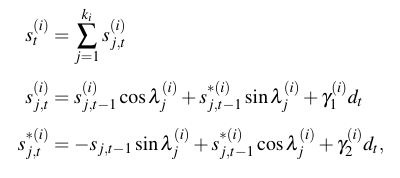

Pelo o que entendi, o TBATS é mais recomendado quando queremos calcular um série com sazonalidade múltipla univariada, já que este modelo não aceita variáveis exógenas, se quisermos utilizar multiplas variáveis, devemos utilizar o modelo SARIMAX realizando uma transformação de Fourier nas variáveis exógenas.



In [4]:
def plot_predictions(model: TBATS | BATS, dataset: pd.Series, year: int = 2019) -> None:
    fig = (
        dataset
        [dataset.index.year == year]
        .to_frame()
        .assign(
            pred = model.predict(fh=pd.date_range(start="2019-01-01", end="2020-01-01", freq="H"))
        )
        .rename(columns={"qnt_viagens": "y"})
        .pipe(
            px.line,
            y = ["y", "pred"],
        )
    )
    
    fig.show()
    
    
def train_tbats_model(dataset: pd.Series, plot: bool, arma_erros: bool, box_cox: bool, sp: list[float | int] | float | int, train_dataset: pd.Series) -> TBATS:
    model = TBATS(
        sp = sp,
        use_arma_errors = arma_erros,
        use_box_cox = box_cox,
        show_warnings = False,
    )
    model.fit(train_dataset)
    
    if plot:
        plot_predictions(model, dataset)
        
    return model
        

In [5]:
# Variaveis
sp = [24, 168]
train_dataset = dataset[dataset.index.year == 2018]

In [6]:
TBATS_model_V1 = train_tbats_model(dataset=dataset, plot=True, arma_erros=False, box_cox=False, sp=sp, train_dataset=train_dataset)

In [7]:
TBATS_model_V2 = train_tbats_model(dataset, plot=True, arma_erros=True, box_cox=False, sp=sp, train_dataset=train_dataset)

In [8]:
TBATS_model_V3 = train_tbats_model(dataset, plot=True, arma_erros=True, box_cox=True, sp=sp, train_dataset=train_dataset)

#  Consolidando os resultados numa tabela

In [61]:
def evaluate_time_series(df, model):
    actual = df['Y']
    predicted = df['pred']

    # Calculate MAE
    mae = np.mean(np.abs(actual - predicted))

    # Calculate MAPE
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100

    # Calculate RMSE
    rmse = np.sqrt(np.mean((actual - predicted) ** 2))

    # Calculate R-squared (R2)
    mean_actual = np.mean(actual)
    ss_total = np.sum((actual - mean_actual) ** 2)
    ss_residual = np.sum((actual - predicted) ** 2)
    r2 = 1 - (ss_residual / ss_total)

    # Calculate MSE
    mse = np.mean((actual - predicted) ** 2)

    # Create a DataFrame with the metrics
    metrics_df = pd.DataFrame({
        'MAE': [mae],
        'MAPE': [mape],
        'RMSE': [rmse],
        'R2': [r2],
        'MSE': [mse],
        'model' : [model]
    })

    return metrics_df

def create_df_results(model_list: list[list[str, TBATS]], dataset: pd.Series) -> pd.DataFrame:
    df = pd.DataFrame()
    
    for model, model_name in model_list:
        temp_df = (
            dataset
            .to_frame()
            .assign(
                pred = model.predict(fh=pd.date_range(start="2019-01-01", end="2019-12-31", freq="H"))
            )
            .rename(columns={"qnt_viagens": "Y"})
            [lambda x: x.index.year == 2019]
            .pipe(
                evaluate_time_series,
                model = model_name,
            )
        )
        df = pd.concat([df, temp_df])
        
    return df
        
        

In [63]:
df = create_df_results([[TBATS_model_V1, 'Modelo V1'], [TBATS_model_V2, 'Modelo V2'], [TBATS_model_V3, 'Modelo V3']], dataset)
df

,MAE,MAPE,RMSE,R2,MSE,model
0,29.228584,221.642533,37.160531,0.393718,1380.905049,Modelo V1
0,29.878506,231.803056,37.761984,0.373934,1425.967430,Modelo V2
0,30.956136,60.738849,46.131342,0.065665,2128.100741,Modelo V3
